## <center>**ML School by REU Data Scinece Club**</center>

----
## <center> Неделя №6 </center>

## <center>Семинар: Настраиваемые параметры в Sklearn и Gridsearch</center>

In [ ]:
# анализ данных
import pandas as pd
import numpy as np

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Отключаем предупреждения
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import io
import re

### Загрузка данных

In [ ]:

# Load the train and test datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## EDA

### Быстрое получение основной информации о данных

<div class="alert alert-block alert-info">
<b>Лайфак:</b> существует функция profile_report() из библиотеки pandas_profiling, которая помогает быстро получить основную информацию о статистиках в данных
</div>

In [ ]:
# получим базовый EDA
import pandas_profiling 

train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Обработка пропусков

Проверяем в каких колонках есть пустые данные

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


или другим способом:

In [ ]:
train.columns[train.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Пропусков в столбце 'Age' ~20%, что является допустимым для работы с этим признаком<br>
Заполним пропуски в столбце возраста<br>
Для этого найдем среднюю и медиану столбца

In [ ]:
mean_age = train["Age"].mean(), train["Age"].median()
mean_age

(29.69911764705882, 28.0)

Заполним пропуски одним из найденных значений<br>
Важно, что возраст - целочисленный признак!

In [ ]:
train["Age"] = train["Age"].fillna(int(mean_age[1]))

У столбца с кабиной очень много пропусков (~77%), заполнение пропусков в данном признаке может негативно сказаться на предсказаниях наших моделей, поэтому удалим этот признак<br>
Также, если обратить внимание: столбцы с именем и номером билета не несут в себе полезной информации для предсказания, так как они содержат очень много уникальных значений.<br>
Давайте удалим эти столбцы.

In [ ]:
train = train.drop(columns=['Name','Ticket', 'Cabin'])
test = test.drop(columns=['Name','Ticket', 'Cabin'])

Рассмотрим последний признак с пропусками: 'Embarked'<br>
У этого признака также немного пропусков, поэтому мы можем обработать их<br>
Для этого найдем самое частое значение столбца.

In [ ]:
max_embarked = train["Embarked"].value_counts()
max_embarked

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Заполним пропуски максимальным значением

In [ ]:
train["Embarked"] = train["Embarked"].fillna(max_embarked.index[0])

Проверим, что пропусков вообще не осталось, если это не так, то строчка ниже выдаст ошибку

In [ ]:
assert not train.isnull().values.any()

Также посмотрим на пропуски в тестовой выборке и проделаем те же действия

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         417 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [ ]:
mean_age_test = test["Age"].median()
test["Age"] = test["Age"].fillna(int(mean_age_test))

In [ ]:
mean_fare_test = test["Fare"].median()
test["Fare"] = test["Fare"].fillna(mean_fare_test)

Проверим остались пропуски на тестовом датасете

In [ ]:
assert not test.isnull().values.any()

### Обработка категориальных признаков

In [ ]:
le = LabelEncoder()

train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

train.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare Embarked
0            1         0       3    1  22.0      1      0   7.2500        S
1            2         1       1    0  38.0      1      0  71.2833        C
2            3         1       3    0  26.0      0      0   7.9250        S
3            4         1       1    0  35.0      1      0  53.1000        S
4            5         0       3    1  35.0      0      0   8.0500        S

Разобьем категориальный признак 'Embarked' на 3 столбца и применим бинаризацию

In [ ]:
train = pd.get_dummies(train, columns=["Embarked"])
test = pd.get_dummies(test, columns=["Embarked"])

train.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    1  22.0      1      0   7.2500   
1            2         1       1    0  38.0      1      0  71.2833   
2            3         1       3    0  26.0      0      0   7.9250   
3            4         1       1    0  35.0      1      0  53.1000   
4            5         0       3    1  35.0      0      0   8.0500   

   Embarked_C  Embarked_Q  Embarked_S  
0           0           0           1  
1           1           0           0  
2           0           0           1  
3           0           0           1  
4           0           0           1

In [ ]:
y = train['Survived']
X = train.drop(columns=['Survived'])

X.head()

PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  \
0            1       3    1  22.0      1      0   7.2500           0   
1            2       1    0  38.0      1      0  71.2833           1   
2            3       3    0  26.0      0      0   7.9250           0   
3            4       1    0  35.0      1      0  53.1000           0   
4            5       3    1  35.0      0      0   8.0500           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1

### Разделение данных на обучающую и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Решающее дерево <br>
Решающее дерево - это алгоритм обучения с учителем, способный решать задачи регрессии и классификации.<br>
Решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил (которые называются предикатами). Этот процесс довольно схож с привычным для человека процессом принятия решений. <br><br>
Строится решающее дерево поэтапно. На первом этапе выбирается признак, который наиболее информативен для разделения данных. Затем происходит разделение данных на основе выбранного признака. Этот процесс продолжается до тех пор, пока все листовые узлы не будут содержать данные одного класса (в случае классификации) или пока не будет достигнуто некоторое заранее заданное условие остановки. <br>
На рисунке справа мы видим решаюшую поверхность, порожденную нашими листьями:
<img src='https://yastatic.net/s3/ml-handbook/admin/3_2_41c1793bef.png'>

### Построим простейшую модель на решающем дереве
Импортируем для начала нужную библиотеку из sklearn. Так как мы решаем задачу классфикации, то используем DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Создадим и обучим модель, передав в нее данные из тренировочной выборки

In [ ]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Получим предсказания

In [ ]:
preds_train = model_tree.predict(X_train)
preds_test = model_tree.predict(X_test)

Конечная цель любой модели машинного обучения - предсказание значений целевой переменной на основе входных данных. Однако, для оценки качества модели необходимо использовать метрики, которые отражают степень соответствия предсказанных значений реальным значениям целевой переменной. В данном случае рассматриваются две метрики: Accuracy и F1.<br>
Давайте вспомним, как они считаются:

Accuracy - это метрика, которая отражает долю правильных ответов модели среди всех прогнозов.<br>
F1 — гармоническое среднее значение между точностью (Precision) и полнотой (Recall) <br> 
<img src="https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png" width='500px'> <br>
Модель считается хорошей, если ее значения этих метрик близки к 1.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/495px-Precisionrecall.svg.png" width='300px'>
</center>

Импортируем эти метрики и запишем их более удобно для дальнейшего использования

In [ ]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as f1

In [ ]:
print("Точность на обучении accuracy:", accuracy(y_train, preds_train))
print("Точность на тесте accuracy:", accuracy(y_test, preds_test))

print("\nТочность на обучении f1:", f1(y_train, preds_train, average='binary'))
print("Точность на тесте f1:", f1(y_test, preds_test, average='binary'))

Точность на обучении accuracy: 1.0
Точность на тесте accuracy: 0.75

Точность на обучении f1: 1.0
Точность на тесте f1: 0.6883720930232557


На этапе обучения решающего дерева была получена точность, равная 1, то есть модель предсказала все значения целевой переменной верно. Однако, на этапе тестирования значение метрик (accuracy и f1) оказались гораздо ниже, что говорит о том, что модель плохо справляется с предсказанием значений целевой переменной на новых данных. Это явление называется переобучением модели. <br>

Переобучение возникает, когда модель "запоминает" данные обучающей выборки и не может обобщить полученные знания на новые данные. В решающих деревьях это происходит, когда дерево слишком глубокое и имеет большое количество листьев. В этом случае дерево может "запомнить" каждый пример из обучающей выборки, что приведет к переобучению.<br>

Для борьбы с переобучением в решающих деревьях используются методы регуляризации, такие как ограничение максимальной глубины дерева, установка минимального количества примеров в листе и т.д. Такие методы позволяют создавать более обобщающие деревья.

Посмотрим как выглядят полученные предсказания

In [ ]:
preds_final_test = model_tree.predict(test)
preds_final_test

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Подгрузим библиотеку для визуализации дерева решений

In [ ]:
!pip install graphviz

In [ ]:
from sklearn.tree import export_graphviz
import graphviz # Необходимо для визуализации

### Посмотрим на построенное дерево

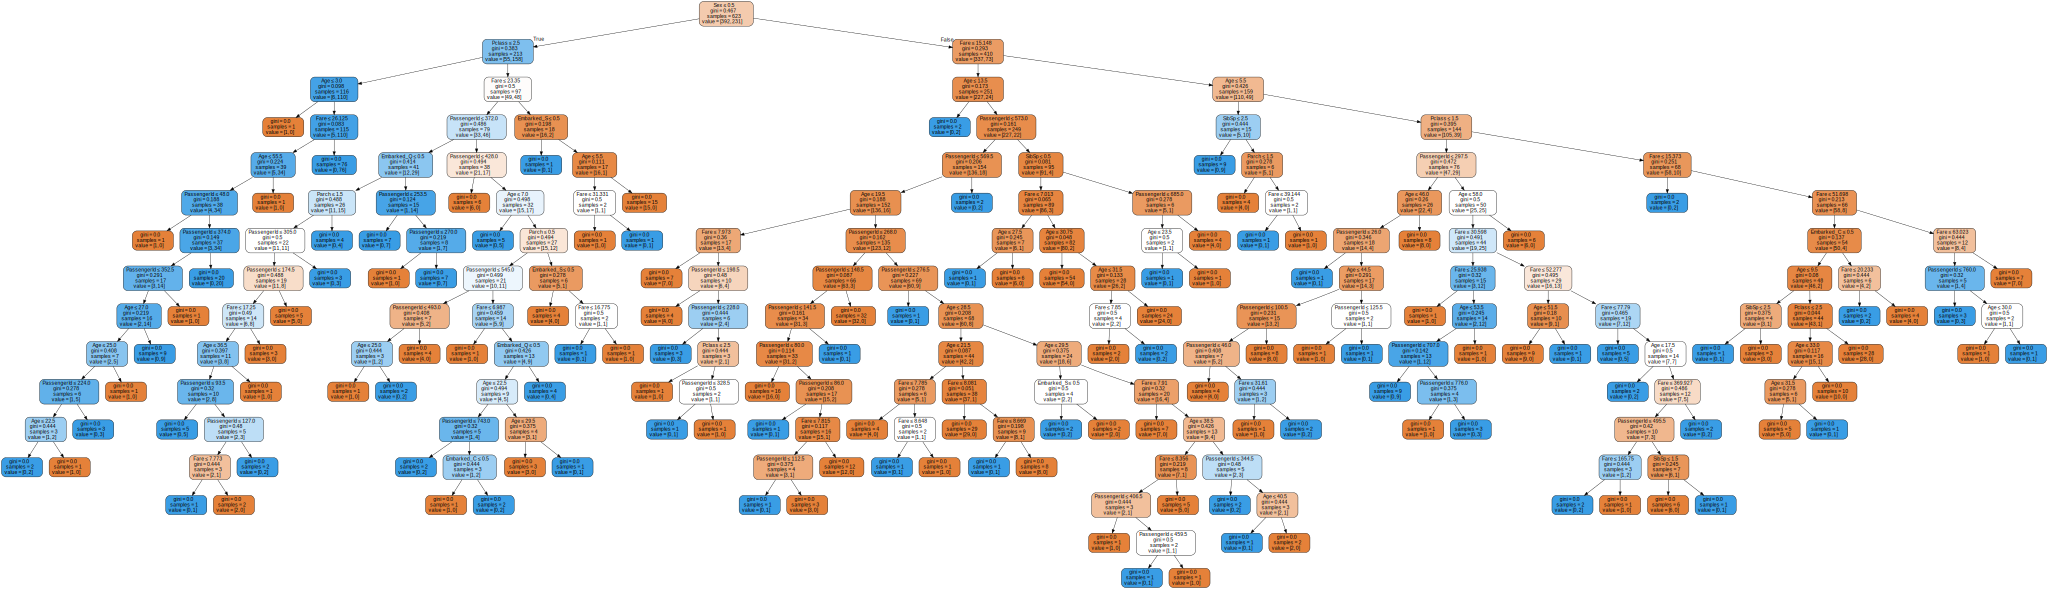

In [ ]:
draw_my_tree = export_graphviz(model_tree, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
graphviz.Source(draw_my_tree)

In [ ]:
def draw_tree(new_tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(new_tree, out_file=None, feature_names=X.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

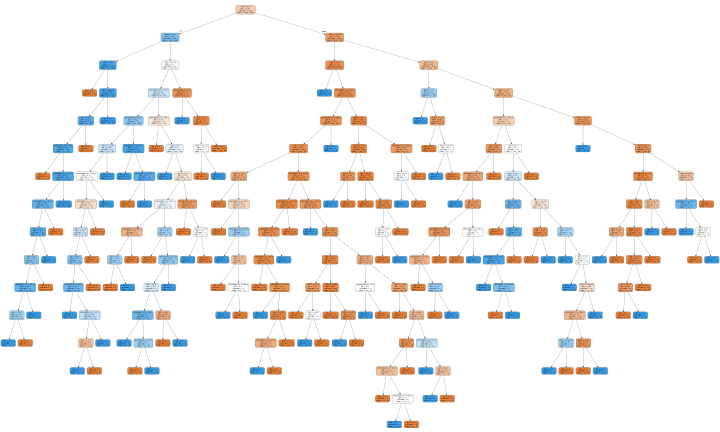

In [ ]:
draw_tree(model_tree, X_train, size=10)

### Получим файл с предсказаниями 

In [ ]:
sub1 = pd.DataFrame({"Survived":preds_final_test})
sub1["PassengerId"] = list(range(892, 892+len(test)))
sub1.set_index('PassengerId', inplace=True)

sub1.to_csv("submition1.csv")
sub1.head()

Survived
PassengerId          
892                 0
893                 0
894                 0
895                 1
896                 1

#### Самая простая модель дерева дала нам accurancy: 0.67224

## Ансамбли решающих деревьев

Решающие деревья могут быстро переобучаться, если они слишком сложны или если используется недостаточное количество данных для обучения.<br>
Чтобы преодолеть эти проблемы, можно использовать ансамбль методов машинного обучения. Ансамбль - это подход, в котором несколько моделей объединяются в одну, чтобы улучшить ее предсказательную способность. Сегодня мы работаем с одним из видов ансамблирования - бэггингом. В бэггинге каждая модель решает задачу независимо от других моделей (обучение идет параллельно), а затем их ответы комбинируются для получения результирующего предсказания.<br>
Случайный лес (Random Forest) - это  бэггинг над решающими деревьями. Он использует несколько деревьев решений для классификации или регрессии, и каждое дерево обучается на подмножестве обучающих данных и подмножестве признаков. Такой подход позволяет уменьшить переобучение и увеличить обобщающую способность модели.

<center>
<img src='https://res.cloudinary.com/dyd911kmh/image/upload/v1661171231/Random_Forest_c9e6024dc2.gif' width='500px'>
</center>

Суть работы случайного леса заключается в том, что каждое дерево строится на случайном подмножестве признаков, а также на случайном подмножестве объектов обучающей выборки. Таким образом, каждое дерево строится на разных данных, что позволяет деревьям быть разнообразными и избежать переобучения. Для принятия решения на новых данных каждое дерево дает свой прогноз, а затем прогнозы объединяются с помощью голосования (в классификации) или усреднения (в регрессии).

Таким образом, использование ансамбля деревьев, в частности случайного леса, позволяет получить более точные и устойчивые предсказания, чем использование отдельных деревьев.

Разберем этот алгоритм подробнее<br>
Откуда мы берем случайное подмножество объектов обучающей выборки? За генерацию этого случайного подмножества отвечает бутстрэп

### Бутстрэп
Этот метод заключается заключается в генерации новой выборки путем многократного выбора объектов с возвращением из исходной выборки. Таким образом, каждый объект исходной выборки может попасть в новую выборку несколько раз, а некоторые могут не попасть вовсе.<br>
![](https://github.com/Yorko/mlcourse.ai/blob/main/img/bootstrap.jpg?raw=true)

### Бэггинг на примере случайного леса
__Алгоритм случайного леса:__ <br>
    1. Из выборки данных случайным образом выбираются подмножества с возвращением (бутстрэп выборка). Каждое подмножество является обучающей выборкой для построения одного дерева решений.<br>
    2. На основе полученных обучающих выборок строятся деревья решений, используя обычный алгоритм построения решающих деревьев. <br>
    3. Для каждого дерева вычисляется прогноз:<br>
    4.1. Для классификации объектов производится голосование по всем деревьям - выбирается класс, который был выбран большинством деревьев.<br>
    4.2. Для регрессии производится усреднение прогнозов всех деревьев.<br>
    5. Оценка качества случайного леса проводится с помощью метрик, таких как accuracy, F1-score, MAE, MSE и других.<br>
    6. В процессе работы с моделью можно проводить настройку гиперпараметров, таких как количество деревьев, глубина деревьев, максимальное количество признаков для разделения и т.д.

Давайте попробуем обучить наш первый случайный лес. Для этого импортируем Random Forest из sklearn. Помним, что мы решаем задачу классификации, поэтому вызываем метод RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Обучим модель и получим предсказания

In [ ]:
model_ranfor = RandomForestClassifier(n_estimators=10)
model_ranfor.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
preds_train = model_ranfor.predict(X_train)
preds_test = model_ranfor.predict(X_test)

print("Точность на обучении:", accuracy(y_train, preds_train))
print("Точность на тесте:", accuracy(y_test, preds_test))

Точность на обучении: 0.985553772070626
Точность на тесте: 0.8208955223880597


Получим предсказания на валидационной выборке

In [ ]:
preds_final_test = model_ranfor.predict(test)

#### Наш скор стал лучше: 0.75837

## Подбор гиперпараметров и кросс-валидация

Грамотный подбор гиперпараметров поможет достугнуть более высокой точности предсказания нашей модели.<br>
Рассмотрим какие есть гиперпараметры и параметры решающего дерева.<br>
Начнем с гиперпараметров, их довольно много, но основные: максимальная глубина дерева, критерий ветвления, минимальное число семплов в листе дерева. Рассмотрим их подробнее:<br>
1. Максимальная глубина дерева - это ограничение на максимальную глубину дерева. Если дерево достигает этой максимальной глубины, то процесс ветвления прекращается. Этот параметр помогает избежать переобучения модели.<br>
2. Критерий ветвления - это функция, используемая для разбиения узлов дерева на две подгруппы. Для решающих деревьев существуют различные критерии ветвления, например, критерий Джини или энтропийный критерий. Они позволяют определить наиболее информативный признак и пороговое значение для ветвления на каждом уровне дерева.<br>
3. Минимальное число сэмплов в листе дерева - это минимальное количество объектов, которые должны попасть в лист дерева, чтобы дальнейшее ветвление не происходило. Это ограничение позволяет избежать создания листьев с небольшим количеством объектов, что может привести к переобучению модели.<br>
<br>
Параметром является сама структура решающего дерева: обучение состоит в том, чтобы на каждом уровне дерева выбрать, по какому признаку должно произойти ветвление и с каким пороговым значением этого признака.

Попробуем обучить модель на разной глубине и количестве деревьев:

In [ ]:
for max_depth in [1, 5, 10]:
    for n_estimators in [5, 100]:
        model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        print('Максимальная глубина: ', max_depth)
        print('Количество деревьев: ', n_estimators)
        print(f'Accuracy на обучении: {accuracy(y_train, preds_train)}')

Максимальная глубина:  1
Количество деревьев:  5
Accuracy на обучении: 0.6340288924558587
Максимальная глубина:  1
Количество деревьев:  100
Accuracy на обучении: 0.7351524879614767
Максимальная глубина:  5
Количество деревьев:  5
Accuracy на обучении: 0.8346709470304976
Максимальная глубина:  5
Количество деревьев:  100
Accuracy на обучении: 0.8603531300160514
Максимальная глубина:  10
Количество деревьев:  5
Accuracy на обучении: 0.9406099518459069
Максимальная глубина:  10
Количество деревьев:  100
Accuracy на обучении: 0.9598715890850722


Мы подбирали гиперпараметры на тестовой выборке, однако такой подбор гиперпараметров на тестовой выборке является неправильным подходом, так как такие подобранные гиперпараметры будут работать хорошо только на этой конкретной выборке данных, но не на других. Вместо этого, рекомендуется использовать метод кросс-валидации для подбора гиперпараметров.<br><br>
Кросс-валидация - это метод, который позволяет оценить качество модели на независимых данных, разбивая исходный набор данных на несколько подвыборок (фолдов) и используя каждую из них в качестве тестовой выборки для модели, обученной на остальных. При этом, для каждой конфигурации гиперпараметров обучается несколько моделей на разных подвыборках, а затем оценки ошибки усредняются. Кросс-валидация позволяет получить более устойчивые оценки качества модели на разных наборах данных и более точно подобрать гиперпараметры, которые будут работать хорошо на новых, ранее не встречавшихся данных.

![](https://machinelearningmastery.ru/img/0-752547-79267.png)

Попробуем кросс-валидацию в деле. Она уже реализована в sklearn, поэтому просто импортируем ее:

In [ ]:
from sklearn.model_selection import cross_val_score

Как и в прошлый раз создаем цикл по двум переменным: глубина дерева и количество деревьев.<br>
Количество разбиений (фолдов), указывается в параметре cv (CrossValidation) <br>
Затем обучаем модель по каждому из гиперпараметров и смотрим на среднюю точность по каждому фолду

In [ ]:
for max_depth in [1, 5, 10]:
    for n_estimators in [5, 100]:
        model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
        print('Максимальная глубина: ', max_depth)
        print('Количество деревьев: ', n_estimators)
        print(f'Средняя accuracy: {np.mean(cv_accuracy)}\n')

Максимальная глубина:  1
Количество деревьев:  5
Средняя accuracy: 0.7496051653660349

Максимальная глубина:  1
Количество деревьев:  100
Средняя accuracy: 0.7271383005078658

Максимальная глубина:  5
Количество деревьев:  5
Средняя accuracy: 0.7832590115198812

Максимальная глубина:  5
Количество деревьев:  100
Средняя accuracy: 0.8169902762294067

Максимальная глубина:  10
Количество деревьев:  5
Средняя accuracy: 0.7672178867831042

Максимальная глубина:  10
Количество деревьев:  100
Средняя accuracy: 0.8025052644617862



## GridSearch и RandomSearch

Самый удобный способ выполнить перебор наборов гиперпараметров — сделать перебор по сетке, также называемый Grid Search:
<br>
Алгоритм перебора следующий:<br>
- Для каждого гиперпараметра фиксируется несколько значений
- Перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется
- Выбирается комбинация, на которой модель показывает лучшее качество

<img src='https://www.relataly.com/wp-content/uploads/2020/07/image-7-768x495.png' width='700px'>

In [ ]:
from sklearn.model_selection import GridSearchCV

Перед началом работы с GridSearchCV рассмотрим его основные параметры:<br>
1. estimator: модель, для которой нужно подобрать гиперпараметры<br>
2. param_grid: словарь параметров, которые нужно перебрать. Ключами словаря являются названия параметров, а значениями - списки возможных значений этих параметров<br>
3. scoring: метрика качества, которую нужно использовать для выбора лучшей комбинации гиперпараметров.
cv: число фолдов в кросс-валидации<br>
4. n_jobs: количество ядер процессора, которые будут задействованы в работе GridSearchCV. Если установить значение -1, то будут использованы все доступные ядра.<br>
5. verbose: уровень вывода. Чем выше значение, тем больше информации будет выведено в процессе выполнения. Значение 0 - минимальный вывод, значение 1 - более подробный вывод (выводится индикатор хода процесса обучения), а значение > 1 - еще более подробный вывод, включая отладочную информацию(выводится информация о каждой эпохе (или итерации) обучения, включая потери и точность модели).<br>
Если обучение занимает много времени, полезно иметь индикатор прогресса, чтобы знать, сколько времени еще осталось до окончания обучения. Если же обучение занимает мало времени, то можно использовать значение 3, чтобы получить подробную информацию о ходе процесса обучения.

In [ ]:
gs_model = RandomForestClassifier()
params = {
    'max_depth': [1, 5, 10],
    'n_estimators': [5, 20, 100],
}

gs = GridSearchCV(gs_model, params, cv=3, scoring='accuracy', verbose=3)
gs.fit(X_train, y_train)

print("Лучшие гиперпараметры:", gs.best_params_)
print("Лучшее значение метрики:", gs.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END .......max_depth=1, n_estimators=5;, score=0.635 total time=   0.0s
[CV 2/3] END .......max_depth=1, n_estimators=5;, score=0.750 total time=   0.0s
[CV 3/3] END .......max_depth=1, n_estimators=5;, score=0.681 total time=   0.0s
[CV 1/3] END ......max_depth=1, n_estimators=20;, score=0.721 total time=   0.0s
[CV 2/3] END ......max_depth=1, n_estimators=20;, score=0.721 total time=   0.0s
[CV 3/3] END ......max_depth=1, n_estimators=20;, score=0.725 total time=   0.0s
[CV 1/3] END .....max_depth=1, n_estimators=100;, score=0.721 total time=   0.2s
[CV 2/3] END .....max_depth=1, n_estimators=100;, score=0.712 total time=   0.2s
[CV 3/3] END .....max_depth=1, n_estimators=100;, score=0.734 total time=   0.2s
[CV 1/3] END .......max_depth=5, n_estimators=5;, score=0.788 total time=   0.0s
[CV 2/3] END .......max_depth=5, n_estimators=5;, score=0.808 total time=   0.0s
[CV 3/3] END .......max_depth=5, n_estimators=5;,

In [ ]:
preds_train = gs.best_estimator_.predict(X_train)
preds_test = gs.best_estimator_.predict(X_test)

print("Ошибка на обучении:", accuracy(y_train, preds_train))
print("Ошибка на тесте:", accuracy(y_test, preds_test))

Ошибка на обучении: 0.85553772070626
Ошибка на тесте: 0.8059701492537313


In [ ]:
preds_final_test = gs.best_estimator_.predict(test)

#### Получившийся скор: 0.76315

При подборе гиперпараметров с помощью метода Grid Search возможно получение очень большого числа комбинаций параметров, что значительно увеличивает время перебора и затрудняет нашу задачу. Чтобы решить эту проблему, придумали метод случайного подбора гиперпараметров, который называется Random Search.<br>
В методе Random Search для каждого гиперпараметра задается распределение, из которого случайным образом выбирается его значение. Затем комбинация гиперпараметров формируется с помощью сэмплирования из этих распределений. Таким образом, метод Random Search позволяет получить набор случайных комбинаций гиперпараметров, что может быть более эффективным, чем перебор всех возможных комбинаций, особенно если нужно рассмотреть большое количество гиперпараметров.
![](https://yastatic.net/s3/ml-handbook/admin/8_4_5781994f1e.png)

In [ ]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

в RandomizedSearchCV появляется новый параметр - n_iter<br>
n_iter определяет количество случайных комбинаций гиперпараметров, которые будут протестированы во время выполнения перекрестной проверки в RandomizedSearchCV.<br>

Таким образом, чем больше значение n_iter, тем больше случайных комбинаций гиперпараметров будет протестировано, что может увеличить шансы на обнаружение оптимальной комбинации гиперпараметров. Однако, более высокое значение n_iter также может привести к более высокому времени выполнения, особенно при использовании более сложных моделей и больших объемов данных.

In [ ]:
rs_model = RandomForestClassifier()
params = {
        'max_depth':list(np.arange(50, 100, step=10)),
        'max_samples':(0.5,1),
        'max_features':(0.5,1),
        'n_estimators':np.arange(100, 200, step=20),
        'criterion':['entropy'],
}

rs = RandomizedSearchCV(rs_model, params, cv=3, verbose=1, n_iter=100, scoring='accuracy')
rs.fit(X_train, y_train)

print("Лучшие гиперпараметры:", rs.best_params_)
print("Лучшее значение метрики:", rs.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 100 is smaller than n_iter=200. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие гиперпараметры: {'n_estimators': 120, 'max_samples': 0.5, 'max_features': 0.5, 'max_depth': 70, 'criterion': 'entropy'}
Лучшее значение метрики: 0.8057413600891862


In [ ]:
preds_train = rs.best_estimator_.predict(X_train)
preds_test = rs.best_estimator_.predict(X_test)

print("Ошибка на обучении:", accuracy(y_train, preds_train))
print("Ошибка на тесте:", accuracy(y_test, preds_test))

Ошибка на обучении: 0.9373996789727127
Ошибка на тесте: 0.832089552238806


In [ ]:
preds_final_test = rs.best_estimator_.predict(test)

#### Получившийся скор: 0.77033
Это наш лучший скор! Путем простых манипуляций мы достигли хороших результатов :)

# Подведем итоги:
- Мы разобрали решающие деревья, как они строятся и обучаются<br>
- Разобрали один из методов ансамблирования решающих деревьев - случайный лес<br>
- Вспомнили что такое гиперпараметры модели, как их правильно подбирать с помощью кросс-валидации<br>
- Узнали что такое GridSearch и RandomSearch, научились применять их на практике<br>